## K-means算法与PCA算法的应用举例
在本次实验中，你将使用K-Means算法来对图片进行压缩(imgae compressing). 因而，首先你会在一个2-D的简单数据上进行K-Means的算法实现以得到对K均值算法的直观感受。随后，你需要use the K-means algorithm for image compression  by reducing the number of colors that occur in an image to only those that are most common in that image。
在实验的第二部分，你将使用PCA算法得到人脸图像的低维度表示。

---

### K-means算法基本步骤
1. **随机选取**K(K < m)个样本点作为聚类中心$C_1, C_2, ..., C_K$；
2. 对于m个样本点中的每一个点i，计算它到$C_k$的距离，取距离最小的$C_k^*$作为点$i$的聚类中心；
3. 对于2中每一个聚类，求其中心作为新的聚类中心；
4. 重复2和3直到收敛；
5. 计算**代价函数**, 也即样本点到对应聚类中心的距离的平均值；
6. 重复1-5若干次，取代价函数最小的一个作为最终结果。（5和6选做）
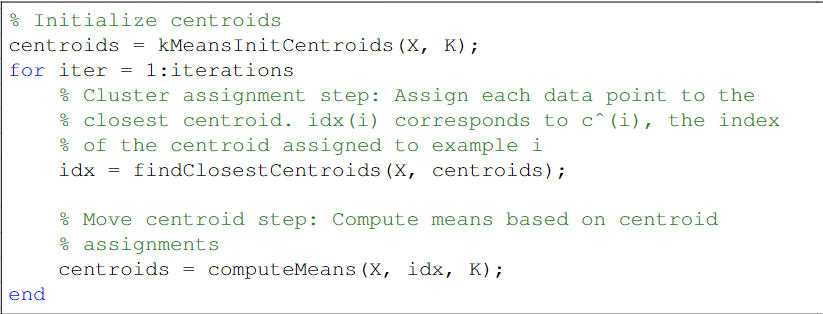

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
# ex7data2.mat - Example Dataset for K-means
# 查看示例数据
dataKmeans = loadmat('data/ex7data2.mat')
X = dataKmeans['X']
X.shape

(300, 2)

> X包含300个点，是2维数据，现在需要进行聚类分析，不妨先进行可视化

Text(0, 0.5, 'x2')

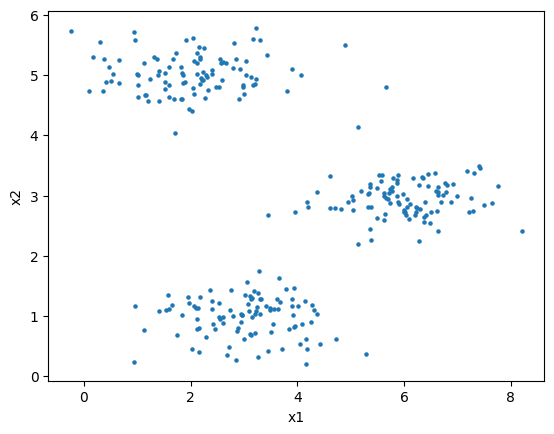

In [12]:
x1 = X[:, 0]
x2 = X[:, 1]
plt.scatter(x1, x2, s=5)
plt.xlabel('x1')
plt.ylabel('x2')

In [58]:
# 可选取K=3, 第一步，选取3个随机聚类中心
def randKCentroids(X, K):
    m = X.shape[0]
    rdint = np.random.randint(0, m, size=K)
    res = []
    for rd in rdint:
        res.append(X[rd, :])
    return np.array(res)

In [59]:
# 我们需要一个数据结构，存储K个聚类
# 它首先是一个list列表，共有K项，每一项是一个字典，有两个键值
# 其中键值centroid对应于聚类中心，是一个n维向量，表示了中心的坐标
# 键值members是一个列表，其中存储着对应于centroid的样本点(行下标)，是一个[0, m)的整数
def initCluster(X, K):
    centroids = randKCentroids(X, K); # 随机选取K个样本点作为centroids
    clusterStructure = []
    for i in range(K):
        ele = {}
        ele['centroid'] = centroids[i, :]
        ele['members'] = []
        clusterStructure.append(ele)
    return clusterStructure
clusters = initCluster(X, 3)
clusters

[{'centroid': array([1.20099981, 4.57829763]), 'members': []},
 {'centroid': array([3.32648885, 1.28019066]), 'members': []},
 {'centroid': array([6.20295231, 2.67856179]), 'members': []}]

In [62]:
# 接下来是聚类划分，函数选取一个样例x和clusterStructure作为输入，计算x与每一个centoid的距离
# 取最小值，将样例x划分到
def splitCluster(X, index, clusters):
    """return X[index, :] 所在的聚类中心下标"""
    res = []
    K = len(clusters)
    x = X[index, :]
    for i in range(K):
        centroid = clusters[i]['centroid']
        delta = x - centroid
        res.append(np.sum(np.multiply(delta, delta)))
    return res.index(min(res))
X[0, :], splitCluster(X, 0, clusters) # 意思是第0个样本应划分到第0个聚类中心点

(array([1.84207953, 4.6075716 ]), 0)

In [63]:
# 对m个样本中心进行1次划分
def dataCluster(X, clusters):
    m = X.shape[0]
    K = len(clusters)
    # 先清空原有结构
    for i in range(K):
        clusters[i]['members'].clear()
    # 然后重新划分
    for i in range(m):
        ci = splitCluster(X, i, clusters)
        clusters[ci]['members'].append(i)
dataCluster(X, clusters)
len(clusters[0]['members']), len(clusters[1]['members']), len(clusters[2]['members'])

(98, 104, 98)

In [64]:
# 接下来是中心移动
def centroidMove(X, clusters):
    K = len(clusters)
    n = X.shape[1]
    for i in range(K):
        # 求聚类所有点的均值
        memi = clusters[i]['members']
        mi = len(memi)
        if mi == 0:
            continue
        avg = np.zeros(n)
        for j in range(mi):
            avg = avg + X[memi[j], :]
        avg = avg / mi
        # 均值赋给centroid
        clusters[i]['centroid'] = avg

centroidMove(X, clusters)
clusters[0]['centroid'], clusters[1]['centroid'], clusters[2]['centroid'], len(clusters[0]['members']), len(clusters[1]['members']), len(clusters[2]['members'])

(array([1.95399466, 5.02557006]),
 array([3.06584667, 1.05078048]),
 array([6.07115453, 3.00350207]),
 98,
 104,
 98)

In [69]:
# 定义clusters的代价函数
def costFunc(X, clusters):
    K = len(clusters)
    m = X.shape[0]
    cost = 0.0
    for i in range(K):
        ci = clusters[i]['centroid']
        for j in clusters[i]['members']:
            delta = ci - X[j, :]
            cost = cost + np.sum(np.multiply(delta, delta))
    return cost/m

# 定义一些辅助函数
def getCentroids(clusters):
    centroids = []
    K = len(clusters)
    for i in range(K):
        centroids.append(clusters[i]['centroid'])
    return np.array(centroids)

# 得到每个类别包含的样本数
def getMemNum(clusters):
    n_centroid = []
    K = len(clusters)
    for i in range(K):
        n_centroid.append(len(clusters[i]['members']))
    return np.array(n_centroid)
costFunc(X, clusters), getCentroids(clusters), getMemNum(clusters)

(0.8888617321830643,
 array([[6.03366736, 3.00052511],
        [1.95399466, 5.02557006],
        [3.04367119, 1.01541041]]),
 array([100,  98, 102]))

---
#### 以下进行K-means算法

In [70]:
asdcas = np.array([1, 2, 3, 4, 5, 6]).reshape(2, 3)
asdass = np.array([1, 2, 3, 4, 5, 6]).reshape(2, 3)
print(np.sum(np.multiply(asdcas, asdass)))

91


In [71]:
dataKmeans = loadmat('data/ex7data2.mat')
X = dataKmeans['X']
K = 3 # 选取K
def kMeansAlg(X, K, EPS):
    clusters = initCluster(X, K) # 初始化
    n = X.shape[1]
    costs = []
    while(True):
        oldCentroids = getCentroids(clusters)
        dataCluster(X, clusters)
        centroidMove(X, clusters)
        newCentroids = getCentroids(clusters)
        # 用聚类中心不再移动作为收敛标准
        delta = oldCentroids - newCentroids
        eps = np.sum(np.multiply(delta, delta))/(K*n)
        cost = costFunc(X, clusters)
        costs.append(cost)
#         print("eps: ", eps, "cluster: ", getMemNum(clusters), "cost:", cost)
        if eps <= EPS:
            return clusters

clusters = kMeansAlg(X, K, 1e-5)

eps:  0.21880529639009763 cluster:  [ 99  99 102] cost: 0.8924641752468853
eps:  0.00027945349168076434 cluster:  [ 98 100 102] cost: 0.8888617321830647
eps:  0.0 cluster:  [ 98 100 102] cost: 0.8888617321830647


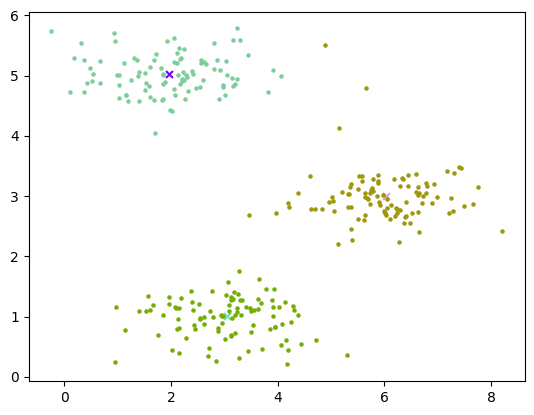

In [85]:
# 将clusters可视化
def plotCluster(X, clusters):
    K = len(clusters)
    for i in range(K):
        colorCentroid = np.random.rand(3).reshape(1, -1)
        colorCluster = np.random.rand(3).reshape(1, -1)
        centroid = clusters[i]["centroid"]
        members = clusters[i]["members"]
        plt.scatter(centroid[0], centroid[1], s=25, marker='x', c=colorCentroid)
        for mb in members:
            plt.scatter(X[mb, 0], X[mb, 1], s=5, c=colorCluster)
    plt.show()

plotCluster(X, clusters)


如上图所示，K-means算法收敛了，kMeansAlg仅执行了一次，下面把cluster保存一下

In [86]:
df = pd.DataFrame(data=clusters)
df.to_csv("./data/clusters.csv", index=False)

## 使用K-means算法对图片进行压缩
基本方法是保留图片中主要的颜色（用聚类中心代替类中的所有点）。图像的每一个像素大小为24bit，是一个RGB三元组，元组中每个数大小范围是0~255（8bit）。
Our image(128x128pxiels) contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to **16** colors.Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

---
首先，我们读取图片，可以使用`plt.imread`读取图片，同时可以使用`plt.imsave(path, array)`保存文件，用`plt.imshow(array)`显示图片

In [117]:
def imgCompress(path, K, EPS):
    imgArr = plt.imread(path)
    X = imgArr.reshape(-1, 3)
    imgCluster = kMeansAlg(X, K, EPS)
    for i in range(K):
        avgColor = imgCluster[i]['centroid']
        for mb in imgCluster[i]['members']:
            X[mb, :] = avgColor
    return X.reshape(imgArr.shape)

这说明我们的输入为128x128的RGB图像，此时RGB值的3个分量为输入特征，128行128列应该先转为1维，也即将数组转为m$\times$3的形式

eps:  0.0009600119994331345 cluster:  [ 229  771 1649  321 2162  606 1798  990  736  715 1029  642 1489 2522
  449  276] cost: 0.013698321014247842
eps:  0.00022134734132808016 cluster:  [ 677  796 1329  358 1883  433 1858  940  786  721  739  835 1375 2134
 1134  386] cost: 0.011751345133901199
eps:  0.00012900504177066298 cluster:  [ 903  743 1270  352 1764  441 1782  975  935  724  725  936 1232 1762
 1380  460] cost: 0.010718284194030857
eps:  6.993035501755049e-05 cluster:  [ 936  743 1265  352 1653  572 1727  945 1087  752  725 1024 1158 1469
 1484  492] cost: 0.010160590997527842
eps:  3.645270166694946e-05 cluster:  [ 946  743 1290  357 1538  678 1696  945 1184  747  731 1075 1093 1303
 1519  539] cost: 0.009889032302293151
eps:  2.242515458267286e-05 cluster:  [ 956  743 1333  369 1415  752 1679  945 1221  752  732 1101 1046 1215
 1540  585] cost: 0.009734694515728826
eps:  1.5548521015064152e-05 cluster:  [ 960  743 1372  376 1338  812 1672  945 1236  761  729 1110 1004 1151


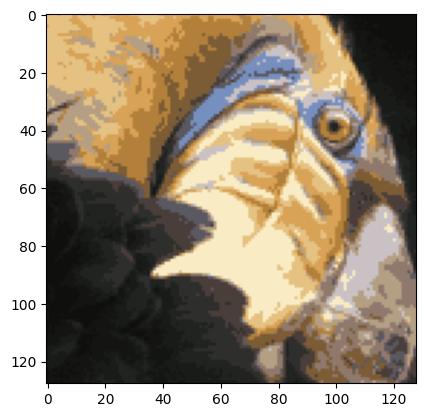

In [118]:
imgPath = "./data/bird_small.png"
imgCompressArray = imgCompress(imgPath, 16, 1e-5)
plt.imshow(imgCompressArray)

In [119]:
plt.imsave('output/imgComp.png', imgCompressArray)